# The Hybrid Montecarlo 

In [45]:
import numpy as np
import matplotlib.pyplot as plt

In [46]:
%config InlineBackend.figure_format = "retina"
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

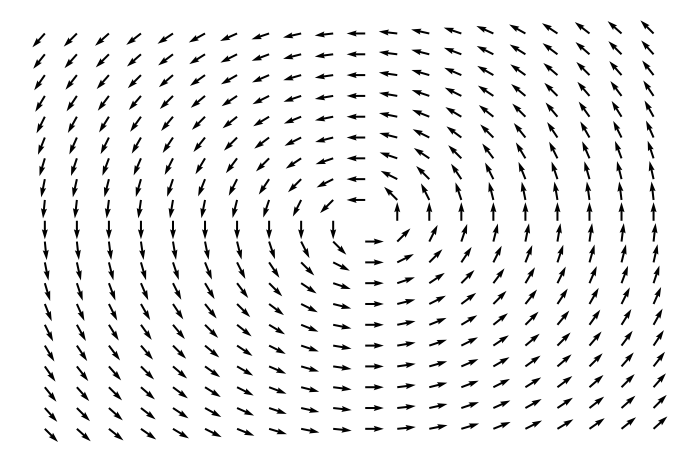

In [50]:
X, Y = np.mgrid[-5:5:0.5, -5:5:0.5]
U = - Y / np.sqrt(X ** 2 + Y ** 2)
V =   X / np.sqrt(X ** 2 + Y ** 2)

plt.quiver(X, Y, U, V)
plt.axis("off");